In [1]:
DOWNSAMPLING_COLORS = {
    'Decimate': '#0072B2', # Blue
    'M4': '#D55E00', # Vermilion
    'MinMax': '#009E73', # Bluish green 
    'LTTB': '#CC79A7', # Reddish purple
    'MinMaxLTTB': '#E69F00' # Orange
}

Decimate: 20 points kept, 80 points removed
MinMax: 20 points kept, 82 points removed
M4: 20 points kept, 87 points removed
LTTB: 20 points kept, 80 points removed
MinMaxLTTB: 20 points kept, 80 points removed


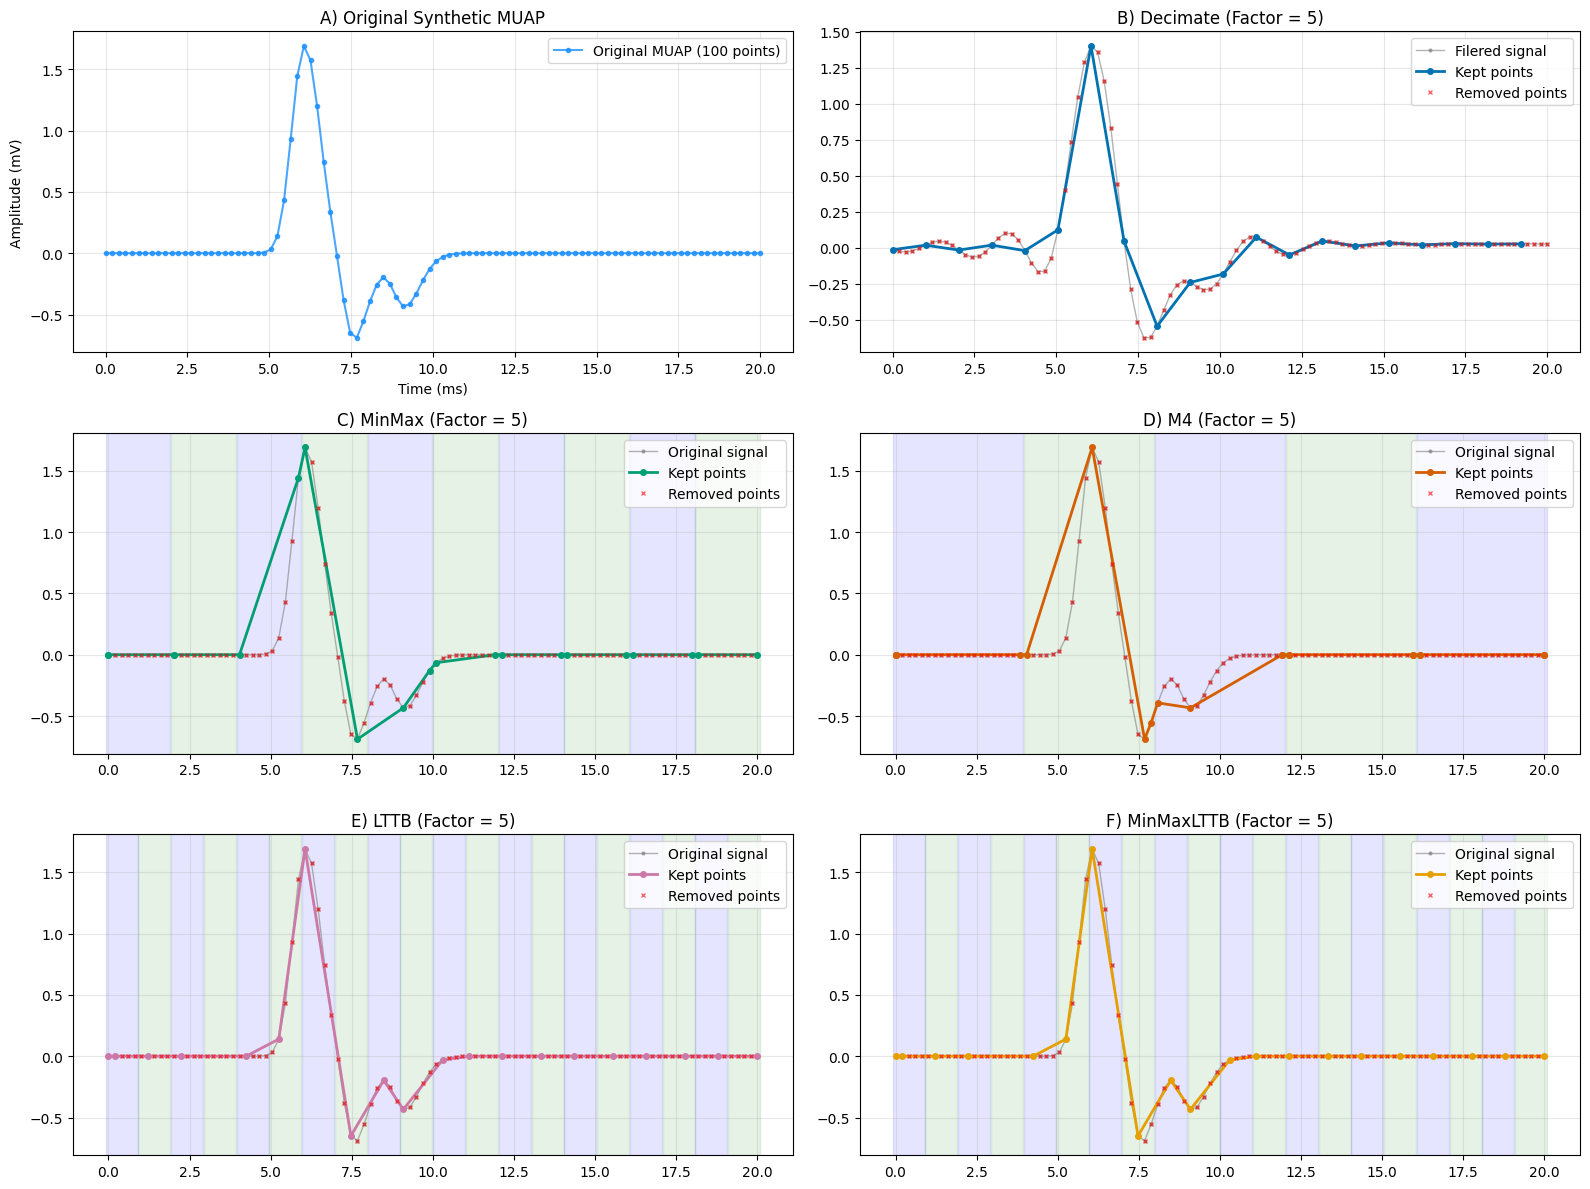

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tsdownsample import LTTBDownsampler, MinMaxDownsampler, M4Downsampler, MinMaxLTTBDownsampler, EveryNthDownsampler
import itertools
from scipy.signal import firwin, filtfilt

def add_bins(ax, t, method, factor):
    n_points = len(t)

    if method == "MinMax":
        nb_bins = (n_points // factor) // 2
    elif method == "M4":
        nb_bins = (n_points // factor) // 4
    elif method in ["LTTB", "EveryNth", "MinMaxLTTB"]:
        nb_bins = n_points // factor
    else:
        return  # Unknown method

    bins = np.searchsorted(t, np.linspace(t[0], t[-1], nb_bins + 1), side="right")
    bins[0] = 0
    bins[-1] = len(t)

    colors = itertools.cycle(["blue", "green"])

    for i in range(len(bins) - 1):
        t_start = t[bins[i]] - 0.09
        t_end = t[bins[i + 1] - 1] + 0.09
        ax.axvspan(t_start, t_end, color=next(colors), alpha=0.1)

def generate_mfap(t, amplitude=1.0, duration=5.0, delay=0.0, shape_variation="biphasic"):
    mfap = np.zeros_like(t)
    t_shifted = t - delay
    mask = t_shifted >= 0
    
    if shape_variation == "biphasic":
        mfap[mask] = amplitude * (
            np.exp(-((t_shifted[mask] - duration / 3) ** 2) / (2 * (duration / 10) ** 2)) -
            np.exp(-((t_shifted[mask] - 2 * duration / 3) ** 2) / (2 * (duration / 10) ** 2))
        )
    
    elif shape_variation == "negative_bump":
        mfap[mask] = -amplitude * np.exp(-((t_shifted[mask] - duration / 2) ** 2) / (2 * (duration / 8) ** 2))
    
    elif shape_variation == "positive_bump":
        mfap[mask] = amplitude * np.exp(-((t_shifted[mask] - duration / 2) ** 2) / (2 * (duration / 8) ** 2))
    
    elif shape_variation == "sharp":
        mfap[mask] = amplitude * (
            np.exp(-((t_shifted[mask] - duration / 3) ** 2) / (2 * (duration / 15) ** 2)) -
            np.exp(-((t_shifted[mask] - 2 * duration / 3) ** 2) / (2 * (duration / 15) ** 2))
        )
    
    return mfap

def generate_muap(n_points, window=20):
    t = np.linspace(0, window, n_points)  # 20 ms window

    mfaps = []

    muap_3 = [
        [0.95, 5.16, 4.63, "sharp"],
        [1.12, 4.86, 4.30, "sharp"],
        [0.81, 4.65, 6.49, "negative_bump"],
        [1.20, 4.82, 5.68, "positive_bump"]
    ]

    for fiber in muap_3:
        amp, dur, delay, shape = fiber
        mfap = generate_mfap(t, amplitude=amp, duration=dur, delay=delay, shape_variation=shape)
        mfaps.append(mfap)

    muap = np.sum(mfaps, axis=0)

    return mfaps, muap, t

def downsample(signal, downsampler, factor):
    mapping = {
        "LTTB": LTTBDownsampler,
        "Decimate": EveryNthDownsampler,
        "MinMax": MinMaxDownsampler,
        "M4": M4Downsampler,
        "MinMaxLTTB": MinMaxLTTBDownsampler
    }
    downsampler_c = mapping[downsampler]
    n_out = len(signal) // factor
    if n_out % 2 != 0 and downsampler_c is MinMaxDownsampler: # has to be even for min max comparisons
        n_out -= 1
    if n_out % 4 != 0 and downsampler_c is M4Downsampler: # has to be a multiple of 4
        n_out -= n_out % 4
    selected_indices = downsampler_c().downsample(signal, n_out=int(n_out))
    return selected_indices

def filter_signal(signal: np.ndarray, q: int, n: int = None) -> np.ndarray:
    if q <= 1:
        return signal
    if n is None:
        half_len = 10 * q
        n = 2 * half_len
    b = firwin(n + 1, 1. / q, window='hamming')
    a = 1.0
    manual_padlen = min(3 * q, len(signal) - 1)
    filtered_signal = filtfilt(b, a, signal, padlen=manual_padlen)
    return np.ascontiguousarray(filtered_signal)
    
# Generate MUAP
mfaps, muap, t = generate_muap(n_points=100, window=20)

methods = ["Decimate", "MinMax", "M4", "LTTB", "MinMaxLTTB"]
downsampling_factor = 5

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

axes[0].plot(t, muap, linestyle='-', color='dodgerblue', marker='o', markersize=3, linewidth=1.5, label="Original MUAP (100 points)", alpha=0.8)
axes[0].set_title("A) Original Synthetic MUAP", fontsize=12)
axes[0].set_ylabel("Amplitude (mV)")
axes[0].set_xlabel("Time (ms)")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

for i, method in enumerate(methods):
    ax = axes[i + 1]  # i+1 because 0 is for original
    
    if method == 'Decimate':
        signal = filter_signal(muap, downsampling_factor)
        label = 'Filered signal'
    else:
        signal = muap
        label = 'Original signal'
        add_bins(ax, t, method, downsampling_factor)
    selected_indices = downsample(signal, method, downsampling_factor)
    removed_indices = np.setdiff1d(np.arange(len(signal)), selected_indices)
    
    ax.plot(t, signal, linestyle='-', color='grey', marker='o', markersize=2, linewidth=1, alpha=0.6, label=label)
    ax.plot(t[selected_indices], signal[selected_indices], linestyle='-', color=DOWNSAMPLING_COLORS[method], marker='o', markersize=4, linewidth=2, label=f"Kept points")
    ax.plot(t[removed_indices], signal[removed_indices], linestyle='none', color='red', marker='x', markersize=3, alpha=0.6, label="Removed points")
    
    ax.set_title(f"{chr(66+i)}) {method} (Factor = {downsampling_factor})", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend()

    print(f"{method}: {len(selected_indices)} points kept, {len(removed_indices)} points removed")

plt.tight_layout()
plt.show()